In [1]:
# Load libraries
import numpy
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [2]:
# Load dataset
data = read_csv('starting_to_work.csv',index_col=0)


In [4]:
data = data[['price_per_square','squares', 'max_floor', 'metro_1km','latitude', 'longitude',
       'parkings_1km', 'distance_to_center',
       'mean_distr_pps']]

### 3. Validation Dataset

In [53]:
# Split-out validation dataset
X = data[[ 'squares', 'max_floor', 'metro_1km','latitude', 'longitude',
       'parkings_1km', 'distance_to_center',
       'mean_distr_pps']]
Y = data['price_per_square']
validation_size = 0.2
seed = 999
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
test_size=validation_size, random_state=seed)

### 4. Evaluate Algorithms: Baseline

In [54]:
# Test options and evaluation metric
num_folds = 2
seed = 999
scoring = 'neg_mean_absolute_percentage_error'

In [55]:
# Spot-Check Algorithms
models = []
models.append(('Лин. Регрессия', LinearRegression()))
models.append(('Лассо', Lasso()))
models.append(('Эластичная сеть', ElasticNet()))
models.append(('K-ближайших соседей', KNeighborsRegressor(n_neighbors=5)))
models.append(('Решающие деревья', DecisionTreeRegressor()))
models.append(('Метод опорных векторов', SVR()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Лин. Регрессия: -0.294483 (0.002066)
Лассо: -0.294480 (0.002061)
Эластичная сеть: -0.294512 (0.001439)
K-ближайших соседей: -0.307437 (0.000029)
Решающие деревья: -0.314379 (0.003307)
Метод опорных векторов: -0.335565 (0.006456)


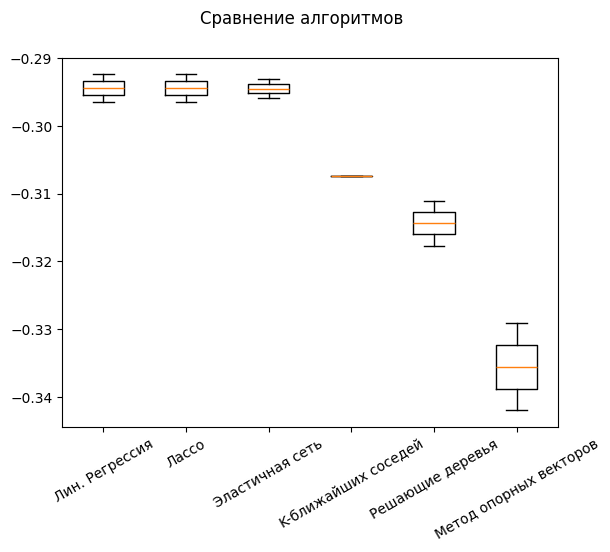

In [65]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Сравнение алгоритмов')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names,rotation=30)
pyplot.show()

### 5. Evaluate Algorithms: Standardize Data

In [73]:
# Standardize the dataset
pipelines = []
pipelines.append(('Станд. Лин. регрессия', Pipeline([('Scaler', StandardScaler()),('LR',
LinearRegression())])))
pipelines.append(('Станд. регуляризация Лассо', Pipeline([('Scaler', StandardScaler()),('LASSO',
Lasso())])))
pipelines.append(('Станд. Эластичная сеть', Pipeline([('Scaler', StandardScaler()),('EN',
ElasticNet())])))
pipelines.append(('Станд. метод К-ближ. соседей', Pipeline([('Scaler', StandardScaler()),('KNN',
KNeighborsRegressor())])))
pipelines.append(('Станд. решающие деревья', Pipeline([('Scaler', StandardScaler()),('CART',
DecisionTreeRegressor())])))
pipelines.append(('Стандарт. метод опорных векторов', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Станд. Лин. регрессия: -0.294483 (0.002066)
Станд. регуляризация Лассо: -0.294483 (0.002066)
Станд. Эластичная сеть: -0.299320 (0.005157)
Станд. метод К-ближ. соседей: -0.287242 (0.000674)
Станд. решающие деревья: -0.319376 (0.004346)
Стандарт. метод опорных векторов: -0.335535 (0.006461)


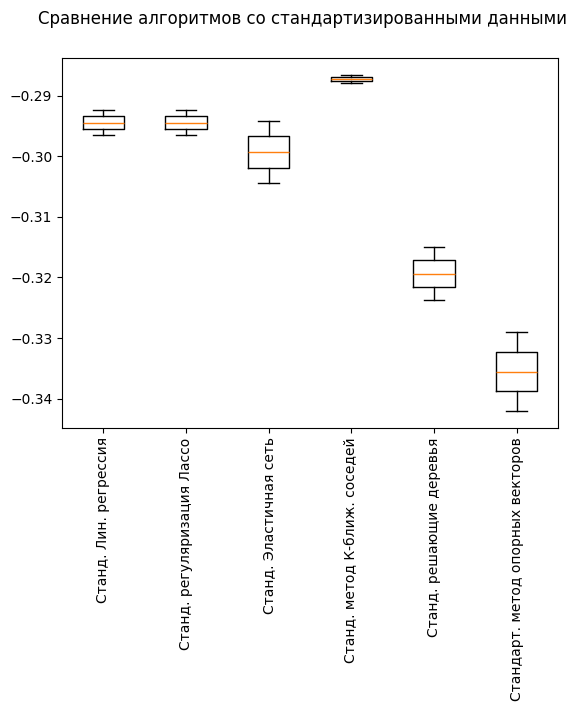

In [76]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Сравнение алгоритмов со стандартизированными данными')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names,rotation = 90)
pyplot.show()

### 6. Algorithm Tuning

In [14]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.284710 using {'n_neighbors': 11}
-0.310613 (0.007706) with: {'n_neighbors': 1}
-0.290752 (0.003075) with: {'n_neighbors': 3}
-0.287525 (0.000890) with: {'n_neighbors': 5}
-0.285658 (0.000682) with: {'n_neighbors': 7}
-0.286933 (0.000157) with: {'n_neighbors': 9}
-0.284710 (0.001874) with: {'n_neighbors': 11}
-0.285289 (0.003279) with: {'n_neighbors': 13}
-0.288226 (0.003318) with: {'n_neighbors': 15}
-0.290783 (0.003547) with: {'n_neighbors': 17}
-0.291729 (0.002500) with: {'n_neighbors': 19}
-0.292876 (0.002914) with: {'n_neighbors': 21}


### 7. Ensemble Methods

In [99]:
# ensembles
ensembles = []
ensembles.append(('Станд. АдаБустинг', Pipeline([('Scaler', StandardScaler()),('AB',
AdaBoostRegressor())])))
ensembles.append(('Станд. Градиентный бустинг', Pipeline([('Scaler', StandardScaler()),('GBM',
GradientBoostingRegressor())])))
ensembles.append(('Станд. Случайный лес', Pipeline([('Scaler', StandardScaler()),('RF',
RandomForestRegressor(n_estimators=10))])))
ensembles.append(('Станд. Доп. деревья', Pipeline([('Scaler', StandardScaler()),('ET',
ExtraTreesRegressor(n_estimators=10))])))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Станд. АдаБустинг: -0.284324 (0.004921)
Станд. Градиентный бустинг: -0.260989 (0.004148)
Станд. Случайный лес: -0.260320 (0.004099)
Станд. Доп. деревья: -0.254619 (0.002279)


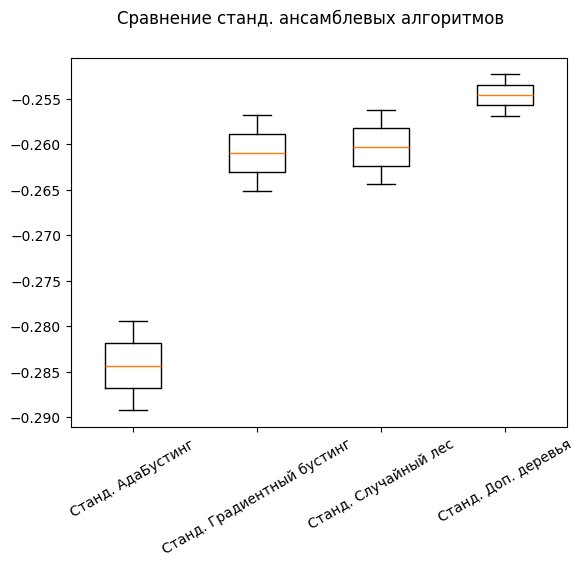

In [102]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Сравнение станд. ансамблевых алгоритмов')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names,rotation = 30)
pyplot.show()

### 7. Ensemble Methods

In [105]:
# ensembles
ensembles = []
ensembles.append(('АдаБустинг',AdaBoostRegressor()))
ensembles.append(('Градиентный бустинг',GradientBoostingRegressor()))
ensembles.append(('Случайный лес',RandomForestRegressor(n_estimators=100)))
ensembles.append(('Дополнительные деревья',ExtraTreesRegressor(n_estimators=100)))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

АдаБустинг: -0.285546 (0.008087)
Градиентный бустинг: -0.260886 (0.003800)
Случайный лес: -0.248374 (0.003626)
Дополнительные деревья: -0.244669 (0.003769)


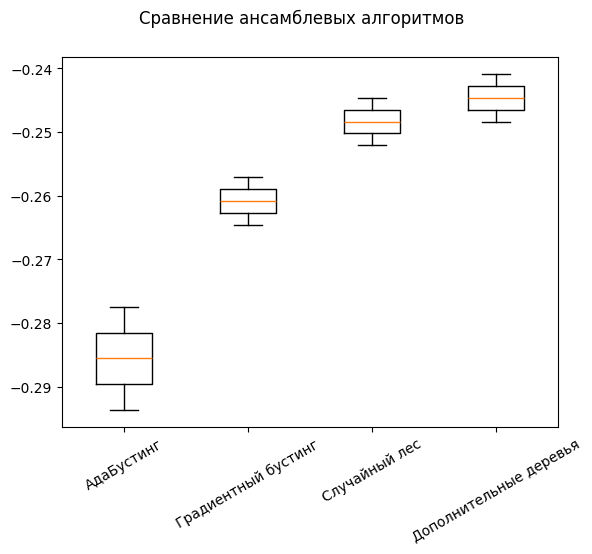

In [108]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Сравнение ансамблевых алгоритмов')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names,rotation = 30)
pyplot.show()

In [111]:
param_grid = {
    'n_estimators': np.array([50, 100, 150, 200, 250, 300, 350, 400]),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

model = ExtraTreesRegressor(random_state=seed)

# Настройка кросс-валидации
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Настройка GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)

# Обучение модели
grid_result = grid.fit(X_train, Y_train)

# Вывод результатов
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.243562 using {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 400}
-0.250459 (0.001850) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
-0.247989 (0.002709) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
-0.248003 (0.002691) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 150}
-0.248029 (0.002752) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
-0.247694 (0.002820) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 250}
-0.247936 (0.003035) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}
-0.247946 (0.002937) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 350}
-0.248481 (0.002462) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400}
-0.254297 (0.0029

In [123]:
param_grid = {
    'n_estimators': np.array([50, 100, 150, 200, 250, 300, 350, 400]),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

model = RandomForestRegressor(random_state=seed)

# Настройка кросс-валидации
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Настройка GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)

# Обучение модели
grid_result = grid.fit(X_train, Y_train)

# Вывод результатов
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.246256 using {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
-0.246717 (0.002827) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
-0.246256 (0.003086) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
-0.246619 (0.002528) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 150}
-0.247026 (0.002266) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
-0.246957 (0.002037) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 250}
-0.246692 (0.001815) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}
-0.246357 (0.002057) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 350}
-0.246524 (0.002222) with: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400}
-0.247776 (0.004

### 8. Finalize Model

In [131]:
rfc = RandomForestRegressor(n_estimators=100,max_depth = None,min_samples_leaf=1,bootstrap=True)
rfc.fit(X, Y)
display(rfc.score(X_train, Y_train))

0.9211449946108158

In [128]:
predictions1 = rfc.predict(X_train)
#Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(Y_train, predictions1))
print(rmse)
print(mean_absolute_error(Y_train, predictions1))
print(mean_absolute_percentage_error(Y_train, predictions1))

23103.33466938182
16675.829013055612
0.0863091824103306


In [129]:
predictions2 = rfc.predict(X_validation)
#Calculate the root mean squared error
display(rfc.score(X_validation, Y_validation))
rmse = np.sqrt(mean_squared_error(Y_validation, predictions2))
print(rmse)
print(mean_absolute_error(Y_validation, predictions2))
print(mean_absolute_percentage_error(Y_validation, predictions2))

0.4497724463640318

57794.95835173812
43021.93944514767
0.21495935093618704


In [132]:
import pickle

with open('rfc.pkl', 'wb') as file:
    pickle.dump(rfc, file)

# # Загрузка модели из файла
# with open('rfc.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)

In [ ]:
import pickle

with open(r'c:\Users\pelik\Documents/anya_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [48]:
rfc = ExtraTreesRegressor(n_estimators=50)
rfc.fit(X_train, Y_train)
display(rfc.score(X_train, Y_train))

0.9999725831378852

In [49]:
predictions1 = rfc.predict(X_train)
#Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(Y_train, predictions1))
print(rmse)
print(mean_absolute_error(Y_train, predictions1))
print(mean_absolute_percentage_error(Y_train, predictions1))

420.95668530542196
28.838351822570218
0.00010741695799984229


In [50]:
predictions2 = rfc.predict(X_validation)
#Calculate the root mean squared error
display(rfc.score(X_validation, Y_validation))
rmse = np.sqrt(mean_squared_error(Y_validation, predictions2))
print(rmse)
print(mean_absolute_error(Y_validation, predictions2))
print(mean_absolute_percentage_error(Y_validation, predictions2))

0.39543973598473947

60581.2998161756
43714.8184050633
0.22003005178952015


In [51]:
import pickle

with open('extr.pkl', 'wb') as file:
    pickle.dump(rfc, file)

# # Загрузка модели из файла
# with open('rfc.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)

# Интерпретация параметров

In [135]:
import pandas as pd

In [141]:
feature_importances = pd.DataFrame(rfc.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                    importance
squares               0.206374
distance_to_center    0.200837
max_floor             0.137506
latitude              0.137156
longitude             0.108559
parkings_1km          0.097259
mean_distr_pps        0.080524
metro_1km             0.031784


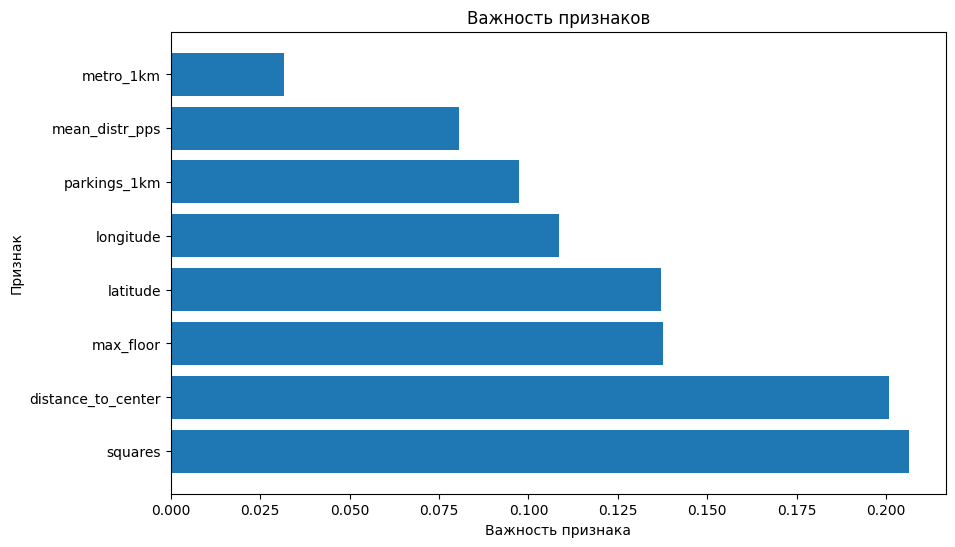

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances['importance'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков')
plt.show()

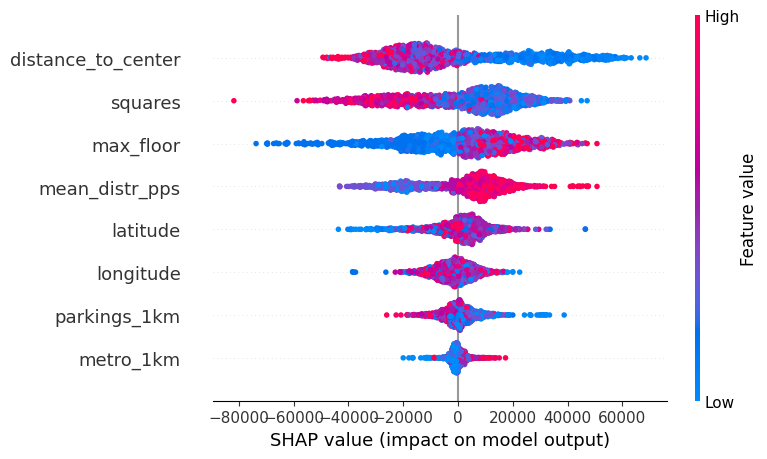

In [143]:
import shap

explainer = shap.Explainer(rfc)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [146]:

shap_means = (shap_values).mean(axis=0)

# Вывод средних значений SHAP
for name, mean_shap in zip(X.columns, shap_means):
    print(f"{name}: {mean_shap}")

squares: -116.29201861829223
max_floor: 251.0200610573661
metro_1km: -164.29105783762756
latitude: 931.5595059651902
longitude: -1371.0091214121162
parkings_1km: 531.3646769899101
distance_to_center: -1242.6154307038264
mean_distr_pps: 1386.4826642082141


In [144]:
pip install lime

^C
Note: you may need to restart the kernel to use updated packages.


In [145]:
from lime.lime_tabular import LimeTabularExplainer



ModuleNotFoundError: No module named 'lime'